## Notebook to run the analysis in the Discussion section of the paper, Fig. 16

In [5]:
from astropy.table import Table
from scipy import interpolate
from astropy.units import Unit

from astropy import constants as const
import itertools
import matplotlib.pyplot as plt
from uncertainties import ufloat
from uncertainties.umath import log
from matplotlib.colors import LogNorm
from matplotlib import  colors
from matplotlib.pyplot import gca
import numpy as np

import emcee
import corner


In [6]:
def f_t_rise(t_f,t_u,fpars= [0.54, 1.34, 0.25]):
            #[0.54462528, 1.33828366, 0.24756259]):
    return t_u*(fpars[0]+fpars[1]*(t_f/t_u)**(fpars[2]))

def f_t_decay_e(t_f,t_u,fpars=[ 1.00,  1.33,  -1.11]):
            #[ 0.69507366,  1.25703129 ,-1.0834316 ]):
    return t_f*(fpars[0]+fpars[1]*(t_f/t_u)**(fpars[2]))



def f_t_delta(delta,t_f,t_r):
    a=t_r/(t_f-t_r)
    return delta-t_r*log(a)


def lc_pars_from_fit(fit_par,use_t_e=True,src_name=''):
    delta_=ufloat(fit_par['delta'],fit_par['delta_err'])
    t_u_=ufloat(fit_par['t_u'],fit_par['t_u_err'])
    t_f_=ufloat(fit_par['t_f'],fit_par['t_f_err'])
    
    if use_t_e is True:
        t_f_=f_t_decay_e(t_f_,t_u_)
    else:
        t_f_=f_t_decay_t2(t_f_,t_u_)
    
    
    
    delta_t=f_t_delta(delta_,t_f_,t_u_)
    
    delta_t_s= ufloat(0, delta_t.nominal_value*0.05, "u systematic")
    delta_t=delta_t+delta_t_s
    t_decay=f_t_decay_e(t_f_,t_u_)
    t_decay_s = ufloat(0, t_decay.nominal_value*0.05, "u systematic")
    t_decay=t_decay+t_decay_s

    t_rise=f_t_rise(t_f_,t_u_)
    t_rise_s = ufloat(0, t_rise.nominal_value*0.05, "u systematic")
    t_rise=t_rise+t_rise_s
    
    

    return {'src_name':src_name,'delta_t':delta_t,'t_rise':t_rise,'t_decay':t_decay}

In [7]:
data_mrk_421_fit={'t_f':126.5,'t_f_err':.1,'t_u':1,'t_u_err':1,'delta':37.4,'delta_err':0.1}
data_mrk_421_lc=lc_pars_from_fit(data_mrk_421_fit,src_name='Mrk 421')

data_mrk_501_fit={'t_f':66.5,'t_f_err':1.5,'t_u':3.4,'t_u_err':1.5,'delta':224,'delta_err':10}
data_mrk_501_lc=lc_pars_from_fit(data_mrk_501_fit,src_name='Mrk 501')

data_3C273_fit={'t_f':30,'t_f_err':3,'t_u':16,'t_u_err':0.5,'delta':264,'delta_err':10}
data_3C273_lc=lc_pars_from_fit(data_3C273_fit,src_name='3C 273')


In [8]:
data_mrk_421_lc

{'src_name': 'Mrk 421',
 'delta_t': 42.23850916461061+/-4.381356977245639,
 't_rise': 5.040861489061932+/-3.931397133721737,
 't_decay': 128.06136591969405+/-6.634072806652359}

In [9]:
data_mrk_501_lc

{'src_name': 'Mrk 501',
 'delta_t': 234.1025098143365+/-15.6776564757458,
 't_rise': 11.53253047174185+/-4.114827090036915,
 't_decay': 73.00385762092068+/-5.061534073612731}

In [10]:
data_3C273_lc

{'src_name': '3C 273',
 'delta_t': 275.9935145328598+/-17.09269193871478,
 't_rise': 37.12584414875525+/-2.162641653429612,
 't_decay': 68.63732797119808+/-4.539546492660519}

In [11]:
def delta_t_obs(R0_obs,beta_exp,nu_0,nu_obs,p,m_B,t_exp_obs=0):
    
    return t_exp_obs+t_peak_obs(R0_obs,beta_exp,nu_0,nu_obs,p,m_B)

def t_peak_obs(R0_obs,beta_exp,nu_0,nu_obs,p,m_B):
    psi=(p+4)/(m_B*(p+2)+4)
    a=(R0_obs/(beta_exp*3E10))
    b=(nu_0/nu_obs)**(psi)
    return a*(b-1)

def t_decay_obs(R0_obs,m_B,beta_exp,nu_0,nu_obs,p):
    psi=(p+4)/(m_B*(p+2)+4)
    a=(R0_obs/(m_B*beta_exp*3E10))
    b=(nu_0/nu_obs)**(psi)
    return (a*b)

def t_rise_obs(R0_obs,beta_exp,nu_0,nu_obs,p,m_B):
    return t_peak_obs(R0_obs,beta_exp,nu_0,nu_obs,p,m_B)/2

In [12]:
def delta_t_obs_1(R0_obs,beta_exp,nu_0,nu_obs,phi,t_exp_obs=0,m_B=None):
    
    return t_exp_obs+t_peak_obs_1(R0_obs,beta_exp,nu_0,nu_obs,phi,m_B)

def t_peak_obs_1(R0_obs,beta_exp,nu_0,nu_obs,phi,m_B=None):
    a=(R0_obs/(beta_exp*3E10))
    b=(nu_0/nu_obs)**(phi)
    return a*(b-1)

def t_decay_obs_1(R0_obs,beta_exp,nu_0,nu_obs,phi,m_B):
    a=(R0_obs/(m_B*beta_exp*3E10))
    b=(nu_0/nu_obs)**(phi)
    return (a*b)

def t_rise_obs_1(R0_obs,beta_exp,nu_0,nu_obs,phi,m_B=None):
    return t_peak_obs_1(R0_obs,beta_exp,nu_0,nu_obs,phi)/2

In [13]:
def log_prior_p(theta,boundary_dict,log_R0_gauss_sigma,use_gauss_R_prob=True):
    log_R0_obs,m_B,log_beta_exp,log_nu0_SSA,p= theta

    accept_condition=  boundary_dict['m_B_min']<m_B<boundary_dict['m_B_max']
    accept_condition_1= boundary_dict['log_beta_exp_min']<log_beta_exp<boundary_dict['log_beta_exp_max']
    accept_condition_2= boundary_dict['log_nu_ssa_min']<log_nu0_SSA<boundary_dict['log_nu_ssa_max']
    accept_condition_3= boundary_dict['p_min']<p<boundary_dict['p_max']
    
    if not( accept_condition and accept_condition_1  and   accept_condition_2 and accept_condition_3):
        return -np.inf
    else:
        s=0
    
        
    if not(boundary_dict['log_R0_min']<log_R0_obs<boundary_dict['log_R0_max']):
        s= -np.inf
    
    if use_gauss_R_prob is True:
        s= np.log(1.0/(np.sqrt(2*np.pi)*log_R0_gauss_sigma))-0.5*(log_R0_obs-boundary_dict['log_R0_mu'])**2/log_R0_gauss_sigma**2
        

    return s

def log_probability_p(theta,nu_obs, data,boundary_dict,log_R0_gauss_sigma,use_gauss_R_prob):
    lp = log_prior_p(theta,boundary_dict,log_R0_gauss_sigma,use_gauss_R_prob=use_gauss_R_prob)
   
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_p(theta,nu_obs, data)


def _log_likelihood_p(trend_func,theta,nu_obs,y,yerr):
    model=trend_func(R0_obs=10**theta[0],m_B=theta[1],beta_exp=10**theta[2],nu_0=10**theta[3],nu_obs=nu_obs,p=theta[4])/86400
    
    sigma2 = yerr ** 2 
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_likelihood_p(theta,nu_obs, data):
    l1=_log_likelihood_p(t_rise_obs,theta,nu_obs,y=data['t_rise'].nominal_value,yerr=data['t_rise'].std_dev)
    l2=_log_likelihood_p(delta_t_obs,theta,nu_obs,y=data['delta_t'].nominal_value,yerr=data['delta_t'].std_dev)
    l3=_log_likelihood_p(t_decay_obs,theta,nu_obs,y=data['t_decay'].nominal_value,yerr=data['t_decay'].std_dev)
    
    return l1+l2+l3

In [14]:

def do_mcmc_analysis_p(data,boundary_dict,gamma_var_t_days_min,gamma_var_t_days_max,nwalkers=200,nu_obs=15E9,size=1000,use_gauss_R_prob=True,log_R0_gauss_sigma=2):

    n_dim=5

    

    log_R_0_min=np.log10(gamma_var_t_days_min*86400*3E10)
    log_R_0_max=np.log10(gamma_var_t_days_max*86400*3E10)
    log_R_0_mu=np.log10((10**log_R_0_min+10**log_R_0_min)*0.5)
    print(log_R_0_min,log_R_0_max,log_R_0_mu)
    boundary_dict['log_R0_min']=log_R_0_min
    boundary_dict['log_R0_max']=log_R_0_max
    boundary_dict['log_R0_mu']=log_R_0_mu
    print(boundary_dict)
    pos = emcee.utils.sample_ball(np.array([log_R_0_mu,1.5,-2,11,0.5]), np.array([1,0.1,0.1,.1,.1]),nwalkers)
    
    sampler = emcee.EnsembleSampler(nwalkers, n_dim, log_probability_p, args=(nu_obs, data,boundary_dict,log_R0_gauss_sigma,use_gauss_R_prob))
    sampler.run_mcmc(pos, size, progress=True);
    flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
    
    return flat_samples,boundary_dict

In [15]:
def do_mcmc_plot_p(samples,boundary_dict,title=None,save_fig=False):
    contour_kwargs=dict(
        colors='black',
        alpha=1,
    )
    
    hist_kwargs=dict(
        color='black'
    )
    
    corener_kwargs = dict(
    smooth=1,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=14),
    quantiles=[0.16, 0.5,0.84],
    levels=(1-np.exp(-0.5),),
    plot_density=True,
    plot_contours=True,
    plot_datapoints=False,
    fill_contours=False,
    show_titles=True,
    max_n_ticks=8,
    title_fmt=".2f",
    contour_kwargs=contour_kwargs,
    hist_kwargs=hist_kwargs,
    color='black',
    range=[[boundary_dict['log_R0_min']*0.9,boundary_dict['log_R0_max']*1.1],
           [boundary_dict['m_B_min']*0.9,boundary_dict['m_B_max']*1.1],
           [boundary_dict['log_beta_exp_min']*0.9,boundary_dict['log_beta_exp_max']*1.1],
           [boundary_dict['log_nu_ssa_min']*0.9,boundary_dict['log_nu_ssa_max']*1.1],
           [boundary_dict['p_min']*0.9,boundary_dict['p_max']*1.1]
          ]
    )
    

    fig = corner.corner(samples,labels=[r'log($R^{\rm obs}_0$)',r'm$_B$',r'log($\beta_{\rm exp}$)',r'log($\nu^{0,\rm obs}_{\rm SSA}$)',r'$p$'],**corener_kwargs)
    fig.axes[18].axvline(np.log10(15E9))

    fig.suptitle(title,fontsize=24)
    fig.savefig('Estimate_par_from_obs/data_%s_analysis_mcmc_p.png'%title.replace(' ','_'),bbox_inches = 'tight',pad_inches = 0)
    return fig

In [16]:
def log_prior(theta,boundary_dict,log_R0_gauss_sigma,use_gauss_R_prob=True):
    log_R0_obs,m_B,log_beta_exp,log_nu0_SSA,phi= theta

    accept_condition=  boundary_dict['m_B_min']<m_B<boundary_dict['m_B_max']
    accept_condition_1= boundary_dict['log_beta_exp_min']<log_beta_exp<boundary_dict['log_beta_exp_max']
    accept_condition_2= boundary_dict['log_nu_ssa_min']<log_nu0_SSA<boundary_dict['log_nu_ssa_max']
    accept_condition_3= boundary_dict['phi_min']<phi<boundary_dict['phi_max']
    
    if not( accept_condition and accept_condition_1  and   accept_condition_2 and accept_condition_3):
        return -np.inf
    else:
        s=0
    
        
    if not(boundary_dict['log_R0_min']<log_R0_obs<boundary_dict['log_R0_max']):
        s= -np.inf
    
    if use_gauss_R_prob is True:
        s= np.log(1.0/(np.sqrt(2*np.pi)*log_R0_gauss_sigma))-0.5*(log_R0_obs-boundary_dict['log_R0_mu'])**2/log_R0_gauss_sigma**2
        
    return s

def log_probability(theta,nu_obs, data,boundary_dict,log_R0_gauss_sigma,use_gauss_R_prob):
    lp = log_prior(theta,boundary_dict,log_R0_gauss_sigma,use_gauss_R_prob=use_gauss_R_prob)
   
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta,nu_obs, data)


def _log_likelihood(trend_func,theta,nu_obs,y,yerr):
    model=trend_func(R0_obs=10**theta[0],m_B=theta[1],beta_exp=10**theta[2],nu_0=10**theta[3],nu_obs=nu_obs,phi=theta[4])/86400
    
    sigma2 = yerr ** 2 
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_likelihood(theta,nu_obs, data):
    l1=_log_likelihood(t_rise_obs_1,theta,nu_obs,y=data['t_rise'].nominal_value,yerr=data['t_rise'].std_dev)
    l2=_log_likelihood(delta_t_obs_1,theta,nu_obs,y=data['delta_t'].nominal_value,yerr=data['delta_t'].std_dev)
    l3=_log_likelihood(t_decay_obs_1,theta,nu_obs,y=data['t_decay'].nominal_value,yerr=data['t_decay'].std_dev)
    
    return l1+l2+l3

In [91]:
import emcee
import corner

def do_mcmc_analysis(data,boundary_dict,gamma_var_t_days_min,gamma_var_t_days_max,nwalkers=200,nu_obs=15E9,size=1000,use_gauss_R_prob=True,log_R0_gauss_sigma=2):

    n_dim=5

    

    log_R_0_min=np.log10(gamma_var_t_days_min*86400*3E10)
    log_R_0_max=np.log10(gamma_var_t_days_max*86400*3E10)
    log_R_0_mu=np.log10((10**log_R_0_min+10**log_R_0_max)*0.5)
    print(log_R_0_min,log_R_0_max,log_R_0_mu)
    boundary_dict['log_R0_min']=log_R_0_min
    boundary_dict['log_R0_max']=log_R_0_max
    boundary_dict['log_R0_mu']=log_R_0_mu
    print(boundary_dict)
    pos = emcee.utils.sample_ball(np.array([log_R_0_mu,1.5,-2,11,0.5]), np.array([.5,0.1,0.1,.1,.1]),nwalkers)
    
    sampler = emcee.EnsembleSampler(nwalkers, n_dim, log_probability, args=(nu_obs, data,boundary_dict,log_R0_gauss_sigma,use_gauss_R_prob))
    sampler.run_mcmc(pos, size, progress=True)
    
    
    samples = sampler.get_chain()
    _,_,n_dim=samples.shape
    fig, axes = plt.subplots(n_dim, figsize=(10, 7), sharex=True)
    for i in range(n_dim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        #ax.set_ylabel(labels[i])
        #ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number");
    tau = sampler.get_autocorr_time(tol=0)
    print(tau)
    
   
    flat_samples = sampler.get_chain(discard=int(size/10), thin=15, flat=True)
    return flat_samples,boundary_dict

In [92]:
def eval_p(psi,m_B):
    return 2*(m_B+4)*psi/(4-psi*m_B)

In [93]:
def eval_phi(p,m_B):
    return (p+4)/(m_B*(p+2)+4)

In [94]:
def do_mcmc_plot(samples,boundary_dict,title=None,save_fig=False):
    contour_kwargs=dict(
        colors='black',
        alpha=1,
    )
    
    hist_kwargs=dict(
        color='black'
    )
    
    corener_kwargs = dict(
    smooth=1,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=14),
    quantiles=[0.16, 0.5,0.84],
    levels=(1-np.exp(-0.5),),
    plot_density=True,
    plot_contours=True,
    plot_datapoints=False,
    fill_contours=False,
    show_titles=True,
    max_n_ticks=8,
    title_fmt=".2f",
    contour_kwargs=contour_kwargs,
    hist_kwargs=hist_kwargs,
    color='black',
    range=[[boundary_dict['log_R0_min']-0.1,boundary_dict['log_R0_max']+.1],
           [boundary_dict['m_B_min']-0.1,boundary_dict['m_B_max']+0.1],
           [boundary_dict['log_beta_exp_min']-0.1,boundary_dict['log_beta_exp_max']+0.1],
           [boundary_dict['log_nu_ssa_min']-0.5,boundary_dict['log_nu_ssa_max']+0.5],
           [boundary_dict['phi_min']-0.1,boundary_dict['phi_max']+0.1]
          ]
    )
    
    
    

    fig = corner.corner(samples,labels=[r'log($R^{\rm obs}_0$)',r'm$_B$',r'log($\beta_{\rm exp}$)',r'log($\nu^{0,\rm obs}_{\rm SSA}$)',r'$\phi$'],**corener_kwargs)
    fig.axes[18].axvline(np.log10(15E9))
    
    fig.suptitle(title,fontsize=24)
    if save_fig is True:
        fig.savefig('Estimate_par_from_obs/data_%s_analysis_mcmc.pdf'%title.replace(' ','_'),bbox_inches = 'tight',pad_inches = 0)
    
    p=eval_p(samples[:,4],samples[:,1])
    
    fig_p=plt.figure(dpi=100,figsize=(4,3))
    ax1=fig_p.add_subplot()
    ax1.hist(p, histtype='step',density=True)
    quantiles=np.quantile(p,[0.16,0.5,0.84])
    print(quantiles)
    print('p',quantiles[1])
    print('p-',quantiles[1]-quantiles[0])
    print('p+',quantiles[2]-quantiles[1])
    ax1.axvline(quantiles[0],ls='--')
    ax1.axvline(quantiles[1],ls='--')
    ax1.axvline(quantiles[2],ls='--')
    ax1.set_xlabel('$p$')
    ax1.set_ylabel('density')
    title1=title+r', p=$%2.2f^{+%2.2f}_{-%2.2f}$'%(quantiles[1],quantiles[2]-quantiles[1],quantiles[1]-quantiles[0])
    fig_p.suptitle(title1,fontsize=12)
    if save_fig is True:
        fig_p.savefig('Estimate_par_from_obs/data_%s_analysis_mcmc_p_hist.pdf'%title.replace(' ','_'),bbox_inches = 'tight',pad_inches = 0)
    return fig,fig_p

In [116]:
size=10000
log_R0_gauss_sigma=3

In [117]:
boundary_dict=dict(m_B_min=1,
                   m_B_max=2,
                   log_beta_exp_min=-4,
                   log_beta_exp_max=0,
                   log_nu_ssa_min=10,
                   log_nu_ssa_max=13,
                   phi_min=1/3,
                   phi_max=1)



  0%|          | 0/10000 [00:00<?, ?it/s]

14.811575005870594 16.559763032876795 16.266419865879104
{'m_B_min': 1, 'm_B_max': 2, 'log_beta_exp_min': -4, 'log_beta_exp_max': 0, 'log_nu_ssa_min': 10, 'log_nu_ssa_max': 13, 'phi_min': 0.3333333333333333, 'phi_max': 1, 'log_R0_min': 14.811575005870594, 'log_R0_max': 16.559763032876795, 'log_R0_mu': 16.266419865879104}


100%|██████████| 10000/10000 [01:50<00:00, 90.67it/s]


[183.22543152 214.3491889  196.01445492 362.35596157 332.49283892]


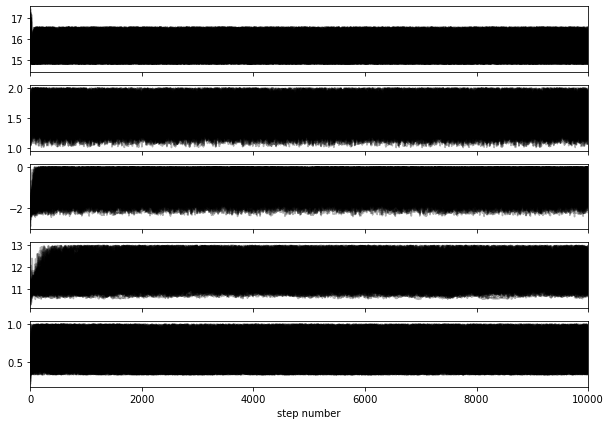

In [118]:
samples_3C723,boundary_dict_3C273=do_mcmc_analysis(data_3C273_lc,boundary_dict,0.25,14,use_gauss_R_prob=False,size=size,log_R0_gauss_sigma=log_R0_gauss_sigma)

[1.43375142 2.2742658  3.45880078]
p 2.274265798377913
p- 0.8405143742974197
p+ 1.1845349767795192


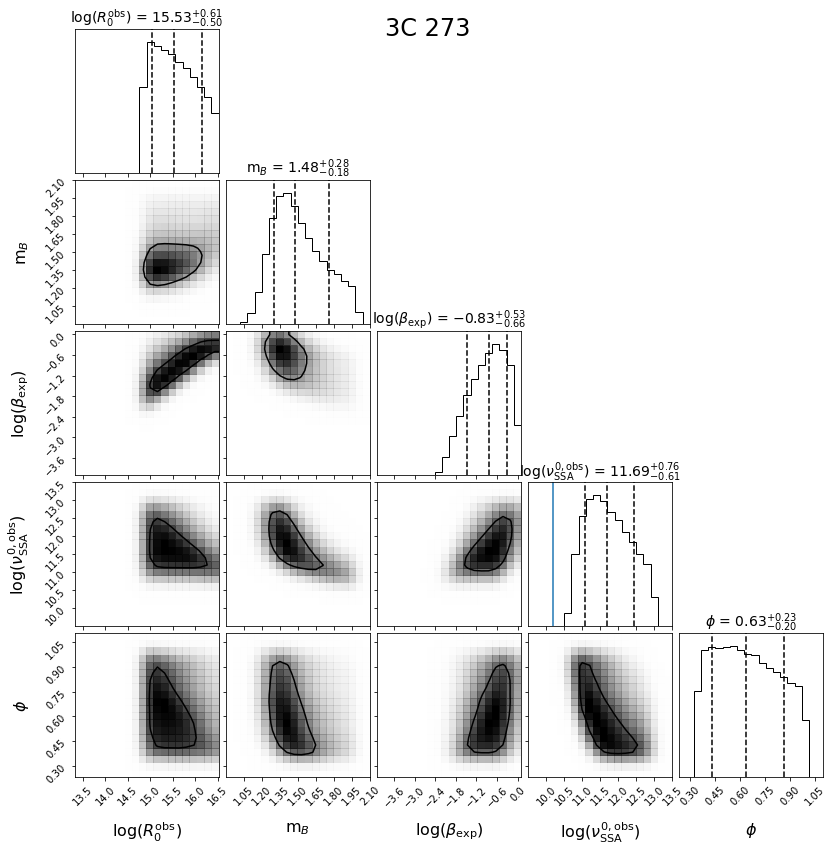

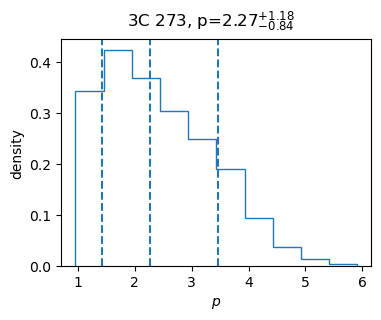

In [129]:

fig_3C273,fig_3C273_p=do_mcmc_plot(samples_3C723,boundary_dict_3C273,title='3C 273',save_fig=True)


  0%|          | 0/10000 [00:00<?, ?it/s]

14.811575005870594 16.559763032876795 16.266419865879104
{'m_B_min': 1, 'm_B_max': 2, 'log_beta_exp_min': -4, 'log_beta_exp_max': 0, 'log_nu_ssa_min': 10, 'log_nu_ssa_max': 13, 'phi_min': 0.3333333333333333, 'phi_max': 1, 'log_R0_min': 14.811575005870594, 'log_R0_max': 16.559763032876795, 'log_R0_mu': 16.266419865879104}


/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [01:26<00:00, 116.24it/s]


[122.53786387 144.78942344 122.56796502 183.47054714 188.17921475]


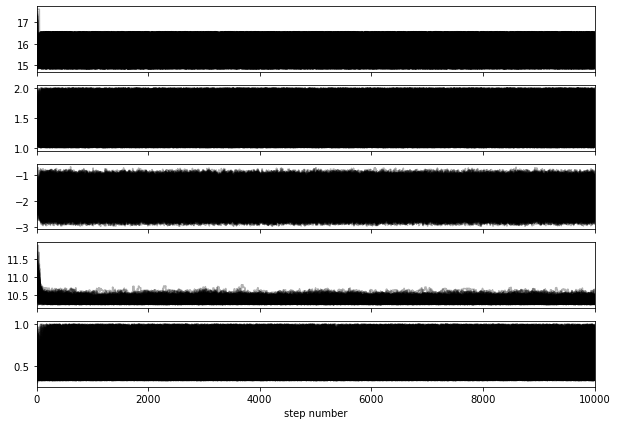

In [136]:
samples_mrk_421,boundary_dict_mrk_421=do_mcmc_analysis(data_mrk_421_lc,boundary_dict,0.25,14,use_gauss_R_prob=False,size=size,log_R0_gauss_sigma=log_R0_gauss_sigma)


[1.25129646 1.93726373 3.19244562]
p 1.9372637252410518
p- 0.6859672644254056
p+ 1.2551818962298626


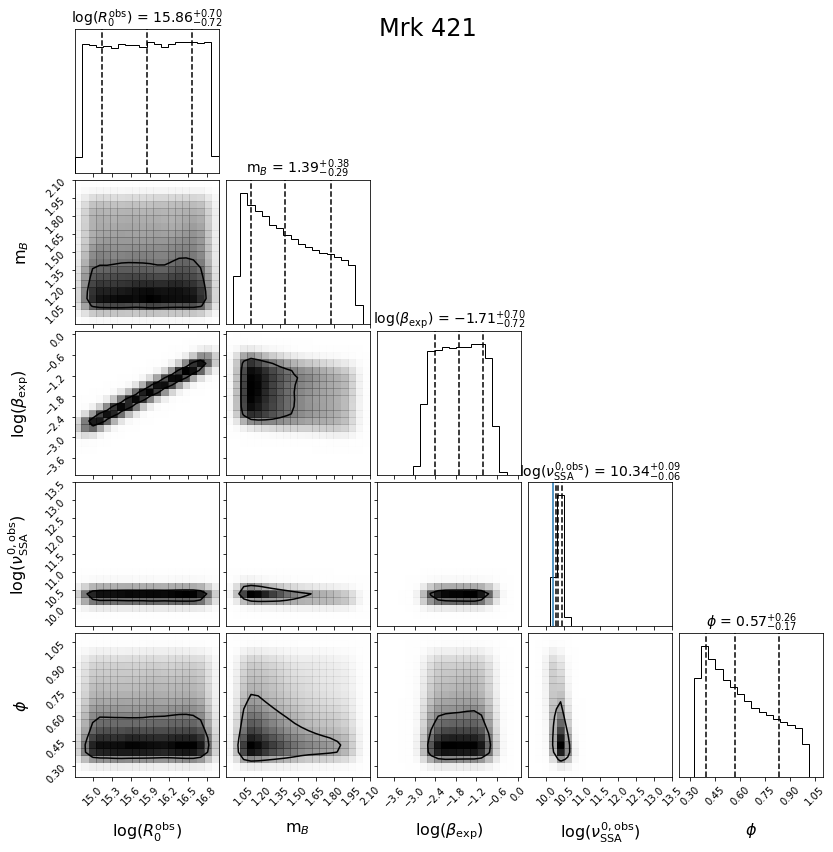

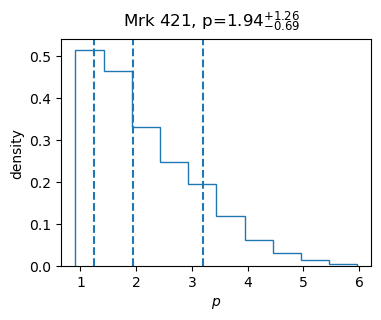

In [135]:
fig_mrk_421,fig_mrk_421_p=do_mcmc_plot(samples_mrk_421,boundary_dict_mrk_421,title='Mrk 421',save_fig=True)


fig=do_mcmc_plot(samples_mrk_421,title='Mrk 421')

  0%|          | 0/10000 [00:00<?, ?it/s]

14.811575005870594 16.559763032876795 16.266419865879104
{'m_B_min': 1, 'm_B_max': 2, 'log_beta_exp_min': -4, 'log_beta_exp_max': 0, 'log_nu_ssa_min': 10, 'log_nu_ssa_max': 13, 'phi_min': 0.3333333333333333, 'phi_max': 1, 'log_R0_min': 14.811575005870594, 'log_R0_max': 16.559763032876795, 'log_R0_mu': 16.266419865879104}


/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [01:50<00:00, 90.29it/s]


[161.37060668 225.95825113 179.55785576 346.89374518 298.37975224]


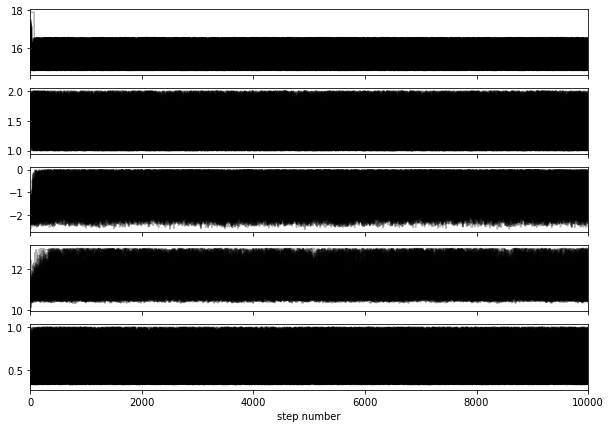

In [122]:
samples_mrk_501,boundary_dict_mrk_501=do_mcmc_analysis(data_mrk_501_lc,boundary_dict,0.25,14,use_gauss_R_prob=False,size=size,log_R0_gauss_sigma=log_R0_gauss_sigma*0.8)


[1.27726065 2.0047306  3.14502369]
p 2.0047306022937006
p- 0.7274699512336427
p+ 1.140293083671751


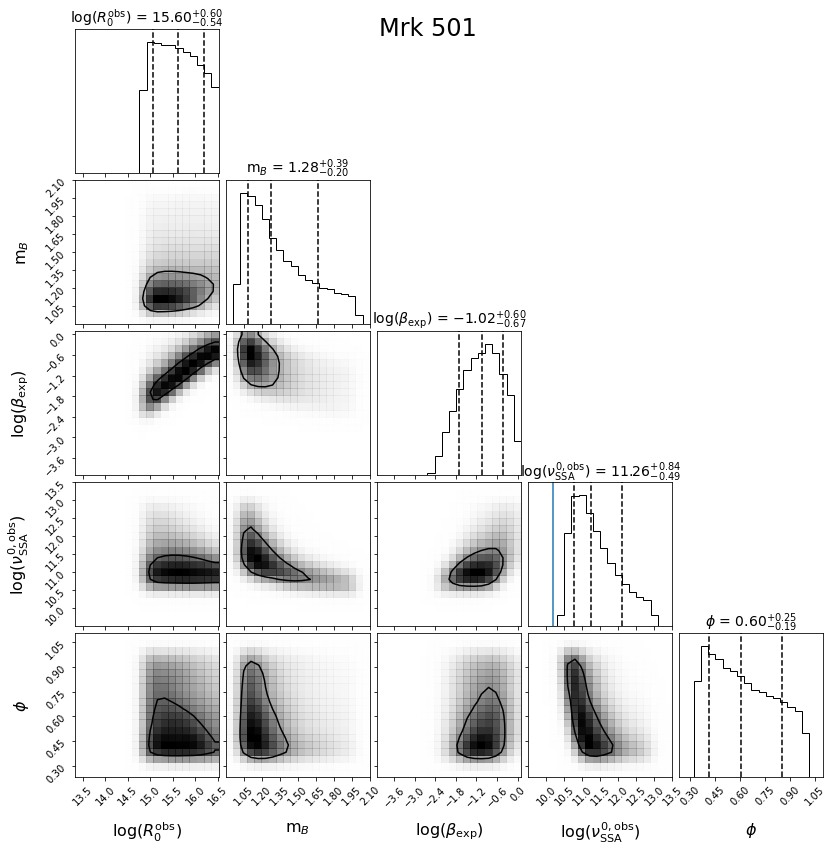

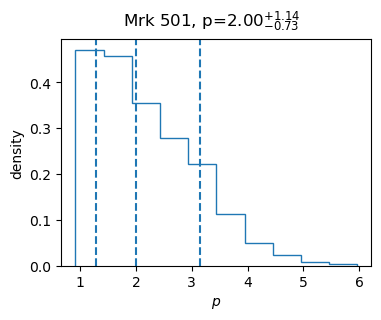

In [131]:
fig_mrk_501,fig_mrk_501_p=do_mcmc_plot(samples_mrk_501,boundary_dict_mrk_501,title='Mrk 501',save_fig=True)

# Validation

In [124]:
from astropy.table import Table
d=t=Table.read('temp_ev_analysis_nu_trends/gamma_radio_delay_fit_vs_freq.ecsv')

data_test=dict(src_name='test',
               delta_t= ufloat(d['delta_T_conv'][2],d['delta_T_conv'][2]*0.05),
               t_rise=ufloat(d['t_rise_conv'][2],d['t_rise_conv'][2]*0.05),
               t_decay=ufloat(d['t_decay_conv'][2],d['t_decay_conv'][2]*0.05))

  0%|          | 0/10000 [00:00<?, ?it/s]/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 13/10000 [00:00<01:21, 122.97it/s]

13.413634997198555 16.413634997198557 16.113039079013895
{'m_B_min': 1, 'm_B_max': 2, 'log_beta_exp_min': -4, 'log_beta_exp_max': 0, 'log_nu_ssa_min': 10, 'log_nu_ssa_max': 13, 'phi_min': 0.3333333333333333, 'phi_max': 1, 'log_R0_min': 13.413634997198555, 'log_R0_max': 16.413634997198557, 'log_R0_mu': 16.113039079013895}


100%|██████████| 10000/10000 [01:21<00:00, 122.01it/s]


[218.91897486 336.57538681 215.86563048 488.47879487 440.65082265]


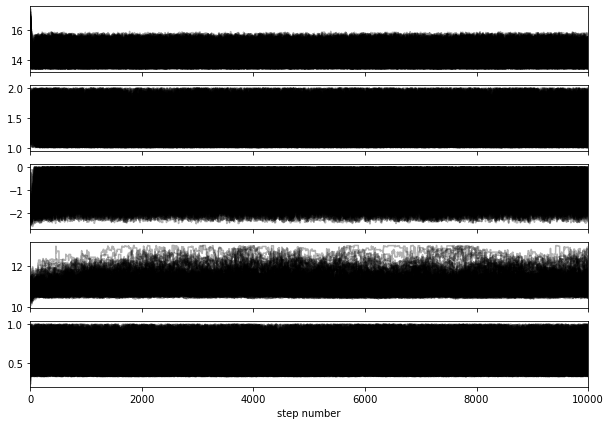

In [125]:
size=10000
samples_test,boundary_dict_test=do_mcmc_analysis(data_test,boundary_dict,.01,10,use_gauss_R_prob=False,size=size,log_R0_gauss_sigma=None)

[1.23174778 1.93523763 3.12070559]
p 1.93523763418147
p- 0.7034898508574081
p+ 1.1854679594067183


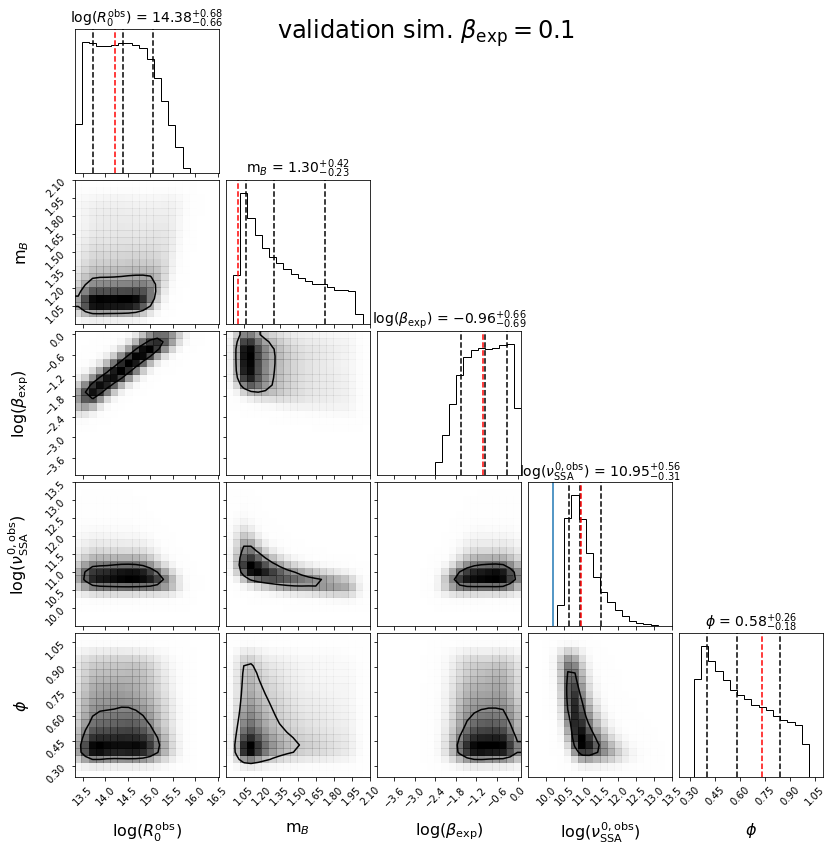

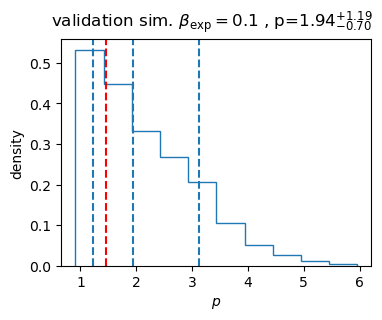

In [130]:
fig_test,fig_test_p=do_mcmc_plot(samples_test,boundary_dict_test,title=r'validation sim. $\beta_{\rm exp}=0.1$ ',save_fig=False)
fig_test.axes[0].axvline(np.log10(1.6E14),c='red',ls='--')
fig_test.axes[6].axvline(1,c='red',ls='--')
fig_test.axes[12].axvline(-1,c='red',ls='--')
fig_test.axes[18].axvline(np.log10(90E9),c='red',ls='--')
fig_test.axes[24].axvline(eval_phi(1.46,1),c='red',ls='--')

fig_test.savefig('Estimate_par_from_obs/data_validation_analysis_mcmc.pdf',bbox_inches = 'tight',pad_inches = 0)
fig_test_p.axes[0].axvline(1.46,c='red',ls='--')
fig_test_p.savefig('Estimate_par_from_obs/data_validation_analysis_mcmc_hist_p.pdf',bbox_inches = 'tight',pad_inches = 0)


In [796]:
boundary_dict_p=dict(m_B_min=1,
                   m_B_max=2,
                   log_beta_exp_min=-4,
                   log_beta_exp_max=0,
                   log_nu_ssa_min=10,
                   log_nu_ssa_max=13,
                   p_min=-2,
                   p_max=5)
samples_test_p,boundary_dict_test_p=do_mcmc_analysis_p(data_test,boundary_dict_p,.01,10,use_gauss_R_prob=False,size=size,log_R0_gauss_sigma=log_R0_gauss_sigma)

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|▏         | 13/1000 [00:00<00:08, 120.67it/s]

13.413634997198555 16.413634997198557 13.413634997198555
{'m_B_min': 1, 'm_B_max': 2, 'log_beta_exp_min': -4, 'log_beta_exp_max': 0, 'log_nu_ssa_min': 10, 'log_nu_ssa_max': 13, 'p_min': -2, 'p_max': 5, 'log_R0_min': 13.413634997198555, 'log_R0_max': 16.413634997198557, 'log_R0_mu': 13.413634997198555}


100%|██████████| 1000/1000 [00:07<00:00, 141.80it/s]


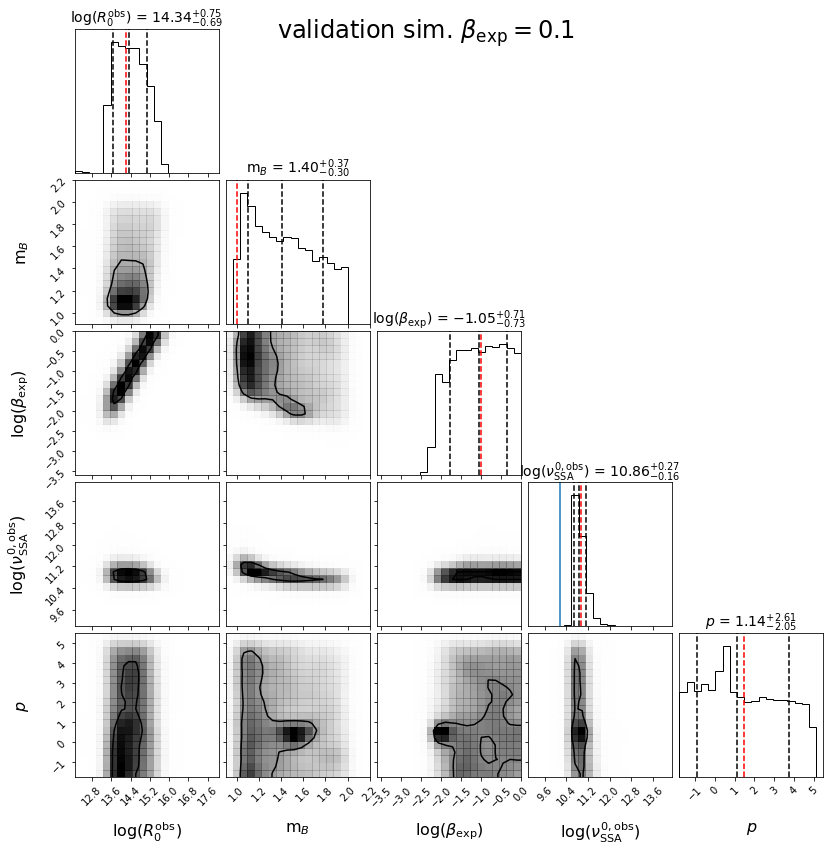

In [797]:
fig_test_p=do_mcmc_plot_p(samples_test_p,boundary_dict_test_p,title=r'validation sim. $\beta_{\rm exp}=0.1$ ',save_fig=False)
fig_test_p.axes[0].axvline(np.log10(1.6E14),c='red',ls='--')
fig_test_p.axes[6].axvline(1,c='red',ls='--')
fig_test_p.axes[12].axvline(-1,c='red',ls='--')
fig_test_p.axes[18].axvline(np.log10(90E9),c='red',ls='--')
fig_test_p.axes[24].axvline(1.46,c='red',ls='--')

In [798]:
10**11.21/(9E10)

1.8020112192877034

In [542]:
10**-0.76

0.17378008287493754

In [450]:
3.5E5/86400/30

0.13503086419753085

# Test with p

In [799]:
boundary_dict_p=dict(m_B_min=1,
                   m_B_max=2,
                   log_beta_exp_min=-4,
                   log_beta_exp_max=0,
                   log_nu_ssa_min=10,
                   log_nu_ssa_max=12,
                   p_min=-2,
                   p_max=5)

In [800]:
size=1000

In [801]:
samples_3C723_p,boundary_dict_3C273_p=do_mcmc_analysis_p(data_3C273_lc,boundary_dict_p,0.25,14,use_gauss_R_prob=False,size=size,log_R0_gauss_sigma=log_R0_gauss_sigma)

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 9/1000 [00:00<00:11, 89.57it/s]

14.811575005870594 16.559763032876795 14.811575005870594
{'m_B_min': 1, 'm_B_max': 2, 'log_beta_exp_min': -4, 'log_beta_exp_max': 0, 'log_nu_ssa_min': 10, 'log_nu_ssa_max': 12, 'p_min': -2, 'p_max': 5, 'log_R0_min': 14.811575005870594, 'log_R0_max': 16.559763032876795, 'log_R0_mu': 14.811575005870594}


100%|██████████| 1000/1000 [00:08<00:00, 115.93it/s]


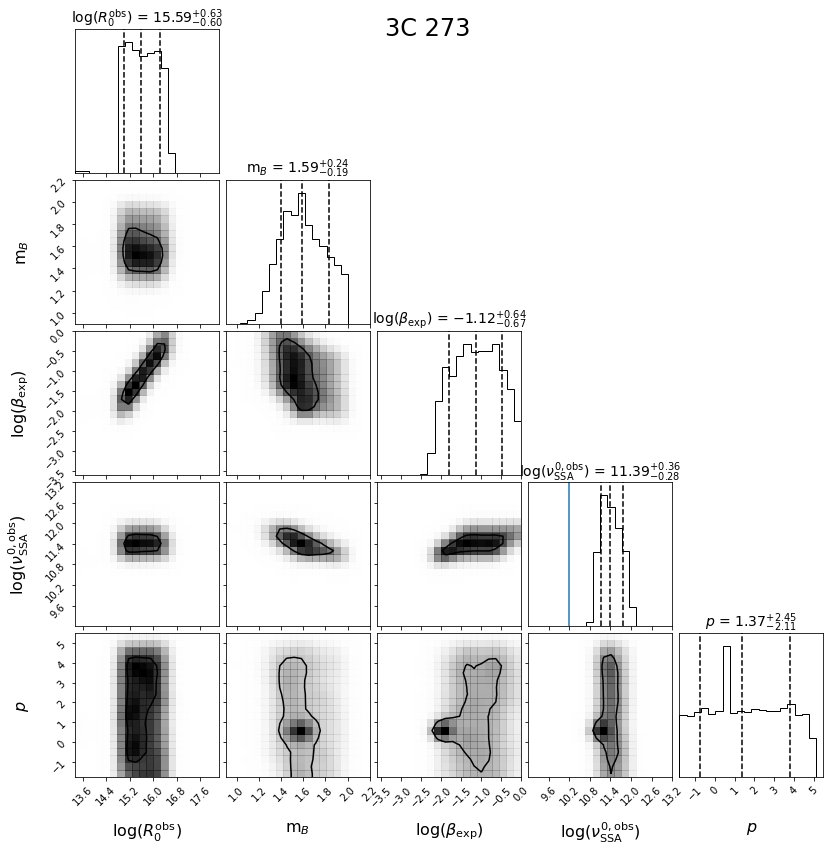

In [802]:
fig_3C273_p=do_mcmc_plot_p(samples_3C723_p,boundary_dict_3C273_p,title='3C 273')


In [803]:
samples_mrk_421_p,boundary_dict_mrk_421_p=do_mcmc_analysis_p(data_mrk_421_lc,boundary_dict_p,0.25,14,use_gauss_R_prob=False,size=size,log_R0_gauss_sigma=log_R0_gauss_sigma)


  0%|          | 0/1000 [00:00<?, ?it/s]/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 10/1000 [00:00<00:10, 93.97it/s]

14.811575005870594 16.559763032876795 14.811575005870594
{'m_B_min': 1, 'm_B_max': 2, 'log_beta_exp_min': -4, 'log_beta_exp_max': 0, 'log_nu_ssa_min': 10, 'log_nu_ssa_max': 12, 'p_min': -2, 'p_max': 5, 'log_R0_min': 14.811575005870594, 'log_R0_max': 16.559763032876795, 'log_R0_mu': 14.811575005870594}


100%|██████████| 1000/1000 [00:07<00:00, 130.03it/s]


In [1]:
fig_mrk_421_p=do_mcmc_plot_p(samples_mrk_421_p,boundary_dict_mrk_421_p,title='Mrk 421')


NameError: name 'do_mcmc_plot_p' is not defined

In [805]:
samples_mrk_501_p,boundary_dict_mrk_501_p=do_mcmc_analysis_p(data_mrk_501_lc,boundary_dict_p,0.25,14,use_gauss_R_prob=False,size=size,log_R0_gauss_sigma=log_R0_gauss_sigma*0.8)


  0%|          | 0/1000 [00:00<?, ?it/s]/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 10/1000 [00:00<00:10, 94.02it/s]

14.811575005870594 16.559763032876795 14.811575005870594
{'m_B_min': 1, 'm_B_max': 2, 'log_beta_exp_min': -4, 'log_beta_exp_max': 0, 'log_nu_ssa_min': 10, 'log_nu_ssa_max': 12, 'p_min': -2, 'p_max': 5, 'log_R0_min': 14.811575005870594, 'log_R0_max': 16.559763032876795, 'log_R0_mu': 14.811575005870594}


100%|██████████| 1000/1000 [00:08<00:00, 119.64it/s]


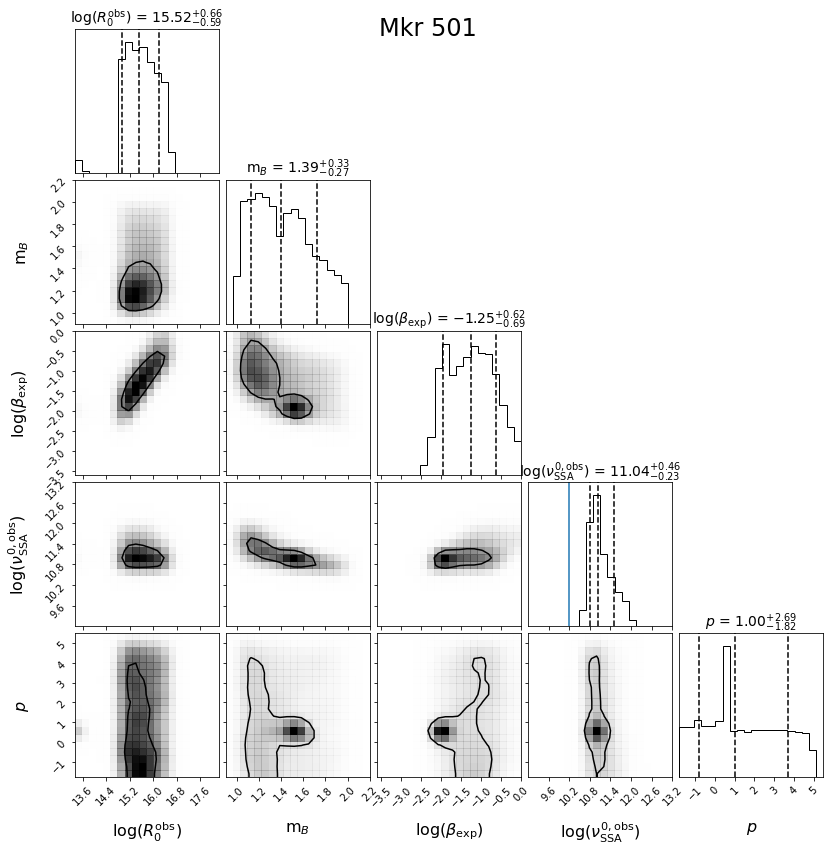

In [806]:
fig_mrk_501_p=do_mcmc_plot_p(samples_mrk_501_p,boundary_dict_mrk_501_p,title='Mrk 501')